In [61]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sklearn.covariance as cor

import sklearn.svm as svm


os.chdir('/Users/caojiawu/test')
data = pd.read_csv('train.csv')




# 把每个年龄存活均值打印出来。需要注意的是部分年龄没有人和没有存活的人是不同的,但图中都显示的是0.

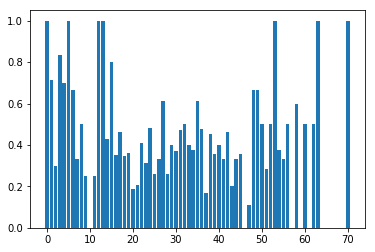

In [68]:
a = data[data['Age'].notnull()][['Survived','Age']]
a['Age'] = a['Age'].astype('int')

b=a.groupby('Age').mean()
plt.bar(range(len(b)),b['Survived'])
plt.show()




# 数据清洗，数据补全
对于可以利用的数据，如果数据是NaN，可以利用已有数据的统计特征进行最小误差引入的补全.

将性别转换为数值型：female=0，male=1.

Embarked取值没有连续性，因此将Embarked做哑变量处理，变成三个特征量：EmbarkedS,EmbarkedC,EmbarkedQ,取值为开关量[0,1]

Pclass同样做哑变量处理，变成三个特征量，Pclass1,Pclass2,Pclass3.



In [81]:
tempData = data

#let female=0 and male=1
tempData['Sex'] = tempData['Sex'].apply(lambda x: 0 if x=='female' else 1)

tempData['Pclass1']=tempData['Pclass'].apply(lambda x: 1 if x==1 else 0)
tempData['Pclass2']=tempData['Pclass'].apply(lambda x: 1 if x==2 else 0)
tempData['Pclass3']=tempData['Pclass'].apply(lambda x: 1 if x==3 else 0)

tempData['EmbarkedC']=tempData['Embarked'].apply(lambda x: 1 if x=='C' else 0)
tempData['EmbarkedQ']=tempData['Embarked'].apply(lambda x: 1 if x=='Q' else 0)
tempData['EmbarkedS']=tempData['Embarked'].apply(lambda x: 1 if x=='S' else 0)


tempData = tempData.drop('PassengerId',1)
tempData = tempData.drop('Name',1)
tempData = tempData.drop('Ticket',1)
tempData = tempData.drop('Pclass',1)
tempData = tempData.drop('Embarked',1)

tempData


,Survived,Sex,Age,SibSp,Parch,Fare,Cabin,Pclass1,Pclass2,Pclass3,EmbarkedC,EmbarkedQ,EmbarkedS
0,0,1,22.0,1,0,7.2500,NaN,0,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,C85,1,0,0,1,0,0
2,1,1,26.0,0,0,7.9250,NaN,0,0,1,0,0,1
3,1,1,35.0,1,0,53.1000,C123,1,0,0,0,0,1
4,0,1,35.0,0,0,8.0500,NaN,0,0,1,0,0,1
5,0,1,NaN,0,0,8.4583,NaN,0,0,1,0,1,0
6,0,1,54.0,0,0,51.8625,E46,1,0,0,0,0,1
7,0,1,2.0,3,1,21.0750,NaN,0,0,1,0,0,1
8,1,1,27.0,0,2,11.1333,NaN,0,0,1,0,0,1
9,1,1,14.0,1,0,30.0708,NaN,0,1,0,1,0,0


# 数据清洗，数据补全
对于无法补全的数据，如果数据为NaN则丢弃整行。

In [82]:

data1 = tempData.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
data1

,Survived,Sex,Age,SibSp,Parch,Fare,Cabin,Pclass1,Pclass2,Pclass3,EmbarkedC,EmbarkedQ,EmbarkedS
1,1,1,38.0,1,0,71.2833,C85,1,0,0,1,0,0
3,1,1,35.0,1,0,53.1000,C123,1,0,0,0,0,1
6,0,1,54.0,0,0,51.8625,E46,1,0,0,0,0,1
10,1,1,4.0,1,1,16.7000,G6,0,0,1,0,0,1
11,1,1,58.0,0,0,26.5500,C103,1,0,0,0,0,1
21,1,1,34.0,0,0,13.0000,D56,0,1,0,0,0,1
23,1,1,28.0,0,0,35.5000,A6,1,0,0,0,0,1
27,0,1,19.0,3,2,263.0000,C23 C25 C27,1,0,0,0,0,1
52,1,1,49.0,1,0,76.7292,D33,1,0,0,1,0,0
54,0,1,65.0,0,1,61.9792,B30,1,0,0,1,0,0


In [19]:

data[['Survived','Pclass']].groupby('Pclass').mean()

data[['Survived','Embarked']].groupby('Embarked').mean()

data[['Survived','Sex']].groupby('Sex').mean()

data['Pclass'].corr(data['Survived'])

-0.3384810359610147